In [1]:
'''
Notebook to specifically study correlations between ELG targets and Galactic foregrounds

Much of this made possible and copied from script shared by Anand Raichoor

Run in Python 3; install pymangle, fitsio, healpy locally: pip install --user fitsio; pip install --user healpy; git clone https://github.com/esheldon/pymangle...

Aug 21: run the codes on the alternative selection of ELGs
'''

import fitsio
import numpy as np
#from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap
import astropy.io.fits as fits
import glob
import os
import healpy as hp
from matplotlib import pyplot as plt

In [7]:
# functions
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180., ra*np.pi/180.

#bmzls = b'N' #if in desi environment
#bmzls = 'N' #if in Python 3; why the difference? Maybe version of fitsio?
def splitcat(cat, bmzls='N'):
    '''
    let's define split into bmzls, DECaLS North, DECaLS South 
    (Anand has tools to make distinct DES region as well)
    one function to do directly, the other just for the indices
    '''
    NN = cat['PHOTSYS'] == bmzls
    d1 = (cat['PHOTSYS'] != bmzls) & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]

def splitcat_ind(cat, bmzls='N'):
    NN = cat['PHOTSYS'] == bmzls
    d1 = (cat['PHOTSYS'] != bmzls) & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return NN,d1,d2


def make_mask(randoms, nside=256, nest=True):
    '''
        Get randoms and project them into BASS/MzLS,
        DECaLS NGC or SGC
    '''
    BASS, NGC, SGC = splitcat(randoms)
    hpBASS = ut.hpixsum(nside,  BASS['RA'], BASS['DEC'], nest=nest)
    hpNGC  = ut.hpixsum(nside,  NGC['RA'],  NGC['DEC'],  nest=nest)
    hpSGC  = ut.hpixsum(nside,  SGC['RA'],  SGC['DEC'],  nest=nest)    
    
    fig, ax = plt.subplots(nrows=3, figsize=(6, 12))
    for i, hpi in enumerate([hpBASS, hpNGC, hpSGC]):
        plt.sca(ax[i])
        hp.mollview(hpi, hold=True, nest=nest)
    plt.show()
    return hpBASS>0.0, hpNGC>0.0, hpSGC>0.0  # we want the binary masks



def plotvshp(r1, d1, sys, rng, 
             gdzm=20, ebvm=0.15, useMCeff=True, 
             correctstar=False, title='', effac=1., south=True, ax=None, hold=False):
    '''
        plot N/Nbar vs systematics
    '''
    
    w  = hpq['GALDEPTH_Z'] > gdzm
    w &= hpq['EBV'] < ebvm
    w &= r1 > 0.0 
    
    if useMCeff:
        w &= mcl > 0
    if sys != 'gdc' and sys != 'rdc' and sys != 'zdc':
        sm = hpq[w][sys]
    else:
        if sys == 'gdc':
            print('g depth, extinction corrected')
            sm = hpq[w]['GALDEPTH_G']*np.exp(-3.214*hpq[w]['EBV'])
        if sys == 'rdc':
            sm = hpq[w]['GALDEPTH_R']*np.exp(-2.165*hpq[w]['EBV'])
        if sys == 'zdc':
            sm = hpq[w]['GALDEPTH_Z']*np.exp(-1.211*hpq[w]['EBV'])
            
    ds = np.ones(len(d1))
    if correctstar:
        ds = ws.copy()
    dmc = np.ones(len(d1))
    if useMCeff:
        dmc = mcl**effac
        
        
    hd1   = np.histogram(sm, weights=d1[w]*ds[w]/dmc[w], range=rng)
    hdnoc = np.histogram(sm, weights=d1[w],bins=hd1[1],  range=rng)
    #print(hd1)
    hr1   = np.histogram(sm,weights=r1[w],bins=hd1[1],  range=rng)
    #print(hr1)
    
    lelg  = np.sum(d1[w])
    lrelg = np.sum(r1[w])
    print(lelg, lrelg)
    
    xl = []
    for i in range(0,len(hd1[0])):
        xl.append((hd1[1][i]+hd1[1][i+1])/2.)
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.errorbar(xl,hd1[0]/hr1[0]/(sum(d1[w]*ds[w]/dmc[w])/sum(r1[w])),
                 np.sqrt(hd1[0])/hr1[0]/(lelg/lrelg),fmt='ko')
    if useMCeff:
        ax.plot(xl,hdnoc[0]/hr1[0]/(sum(d1[w])/sum(r1[w])),'k--')
    print(hd1[0]/hr1[0]/(sum(d1[w]*ds[w]/dmc[w])/sum(r1[w])))
    #plt.title(str(mp)+reg)
    ax.plot(xl,np.ones(len(xl)),'k:')
    ax.set_ylabel('relative density')
    ax.set_xlabel(sys)
    ax.set_ylim(0.7,1.3)
    #ax.set_title(title)
    ax.text(0.1, 0.9, title, transform=ax.transAxes)
    if not hold:plt.show()    

In [3]:
'''
    Make this work on my local computer
'''
host = os.getenv('HOST')
if host == 'lakme':
    pixfn = '/home/mehdi/data/pixweight-dr8-0.31.1.fits'
    os.environ["SCRATCH"] = "/home/mehdi/data/DESIashley/"
    import sys
    sys.path.append('/home/mehdi/github/LSSutils')
    import LSSutils.utils as ut    
else:
    pixfn = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'

camb is not installed!


In [4]:
'''
Some information is in pixelized map
get nside and nest from header
'''    
    
hdr        = fits.getheader(pixfn,1)
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
hpq        = fitsio.read(pixfn)
print('columns in pixweight')
print(f'nside : {nside}, nest: {nest}')
for coli in fits.open(pixfn)[1].columns.names:
    print(coli, end=' ')

columns in pixweight
nside : 256, nest: True
HPXPIXEL FRACAREA STARDENS EBV PSFDEPTH_G PSFDEPTH_R PSFDEPTH_Z GALDEPTH_G GALDEPTH_R GALDEPTH_Z PSFDEPTH_W1 PSFDEPTH_W2 PSFSIZE_G PSFSIZE_R PSFSIZE_Z ELG LRG QSO BGS_ANY MWS_ANY ALL STD_FAINT STD_BRIGHT LRG_1PASS LRG_2PASS BGS_FAINT BGS_BRIGHT BGS_WISE MWS_BROAD MWS_MAIN_RED MWS_MAIN_BLUE MWS_WD MWS_NEARBY 

get MC efficiency

In [5]:
MCeff = False      # False if not available
if MCeff:    
    mcf = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHSCHP.fits')
    mmc = np.mean(mcf['EFF'])
    mcl = np.zeros(12*nside*nside)
    for i in range(0,len(mcf)):
        pix = mcf['HPXPIXEL'][i]
        mcl[pix] = mcf['EFF'][i]/mmc

Class : elg  Alternative : True
nest (T/F) True
reading randoms done


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


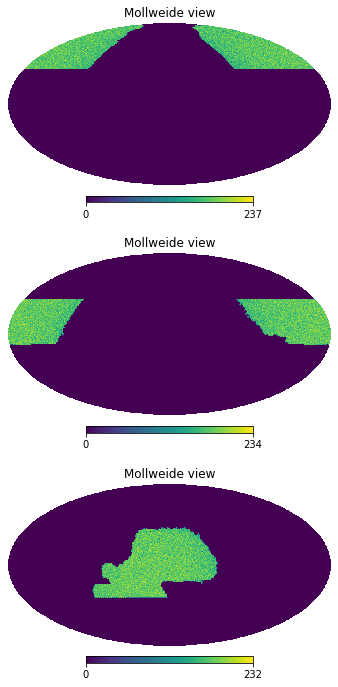

making masks done


In [6]:
alternative = True
Class       = 'elg'
if alternative:
    # first 
    print('Class : {}  Alternative : {}'.format(Class, alternative))
    print('nest (T/F)', nest)
    randoms              = fitsio.read(os.getenv('SCRATCH')+'ELGrandoms.fits')
    print('reading randoms done')
    hpBASS, hpNGC, hpSGC = make_mask(randoms)
    print('making masks done')
    
    kw      = dict(verbose=False, nest=nest)
    hpelg   = hp.read_map('/home/mehdi/data/alternative/'+Class+'_gal256.fits',  **kw)
    hpran   = hp.read_map('/home/mehdi/data/alternative/'+Class+'_ran256.fits',  **kw)
        
    pixlrbm = np.zeros(12*nside*nside)
    pixlgbm = np.zeros(12*nside*nside)
    pixlrdn = np.zeros(12*nside*nside)
    pixlgdn = np.zeros(12*nside*nside)
    pixlrds = np.zeros(12*nside*nside)
    pixlgds = np.zeros(12*nside*nside)
    
    pixlrbm[hpBASS] = hpran[hpBASS]
    pixlgbm[hpBASS] = hpelg[hpBASS]
    pixlrdn[hpNGC]  = hpran[hpNGC]
    pixlgdn[hpNGC]  = hpelg[hpNGC]
    pixlrds[hpSGC]  = hpran[hpSGC]
    pixlgds[hpSGC]  = hpelg[hpSGC]  
else:
    #read in ELGs, put them into healpix
    #ELGs were saved here
    elgf     = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'
    felg     = fitsio.read(elgf)
    dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
    dpix     = hp.ang2pix(nside,dth,dphi,nest)
    
    #
    lelg = len(felg)
    print('Unique PHOTSYS : ', np.unique(felg['PHOTSYS']))
    print('# of ELGs : ', lelg)
    
    #
    #full random file is available, easy to read some limited number; take 1.5x ELG to start with
    path2random = '/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/'
    rall        = fitsio.read(path2random + 'randoms-inside-dr8-0.31.0-all.fits', rows=np.arange(int(1.5*lelg)))
    rall_header = fitsio.read_header(path2random + 'randoms-inside-dr8-0.31.0-all.fits',ext=1)
    
    #
    #cut randoms to ELG footprint
    keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
    print(len(rall[keep]))
    elgbits = [1,5,6,7,11,12,13]
    keepelg = keep
    for bit in elgbits:
        keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
    print(len(rall[keepelg]))
    relg = rall[keepelg]
    
    #write out randoms
    #fitsio.write(os.getenv('SCRATCH')+'/ELGrandoms.fits',relg,overwrite=True)
    
    #put randoms into healpix
    rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
    rpix = hp.ang2pix(nside,rth,rphi,nest=nest)
    
    
    #indices for split
    dbml,ddnl,ddsl = splitcat_ind(felg)
    rbml,rdnl,rdsl = splitcat_ind(relg)
    print(len(felg[dbml]),len(felg[ddnl]),len(felg[ddsl]))
    
    #
    #put into full sky maps (probably not necessary but easier to keep straight down the line)
    pixlrbm = np.zeros(12*nside*nside)
    pixlgbm = np.zeros(12*nside*nside)
    pixlrdn = np.zeros(12*nside*nside)
    pixlgdn = np.zeros(12*nside*nside)
    pixlrds = np.zeros(12*nside*nside)
    pixlgds = np.zeros(12*nside*nside)

    for pix in rpix[rbml]:
        pixlrbm[pix] += 1.
    print('randoms done')
    for pix in dpix[dbml]:
        pixlgbm[pix] += 1.

    for pix in rpix[rdnl]:
        pixlrdn[pix] += 1.
    print('randoms done')
    for pix in dpix[ddnl]:
        pixlgdn[pix] += 1.

    for pix in rpix[rdsl]:
        pixlrds[pix] += 1.
    print('randoms done')
    for pix in dpix[ddsl]:
        pixlgds[pix] += 1.    

In [11]:
slp = -0.35/4000.
b   = 1.1
ws  = 1./(slp*hpq['STARDENS']+b)    
assert len(pixlgds) == 12*nside*nside  # assert the map size

correcting with star density ...  True


13404907.0 25303361.0
[1.00039119 1.00088238 1.00019196 0.99625851 0.98373605 0.99880456
 1.02515909 1.02808919 0.94210294 1.55933767]
13404907.0 25303361.0
[0.96752695 0.99076255 1.02002543 1.00796702 1.00501611 0.98840713
 0.98333009 0.97407305 0.98251091 0.98259883]
g depth, extinction corrected
13404907.0 25303361.0
[1.1639675  1.07560734 1.03589006 1.0209246  0.98845022 0.95907193
 0.96300484 0.97451828 0.99327105 0.98248465]
13404907.0 25303361.0
[1.11845375 1.08061631 1.03474644 1.02302322 1.02354473 1.02641874
 0.99076632 0.97212864 0.974768   0.95644819]
13404907.0 25303361.0
[1.02379749 1.01871045 1.01823958 1.01738486 1.00133529 0.97639074
 0.96814703 0.95782577 0.93812627 0.91390231]


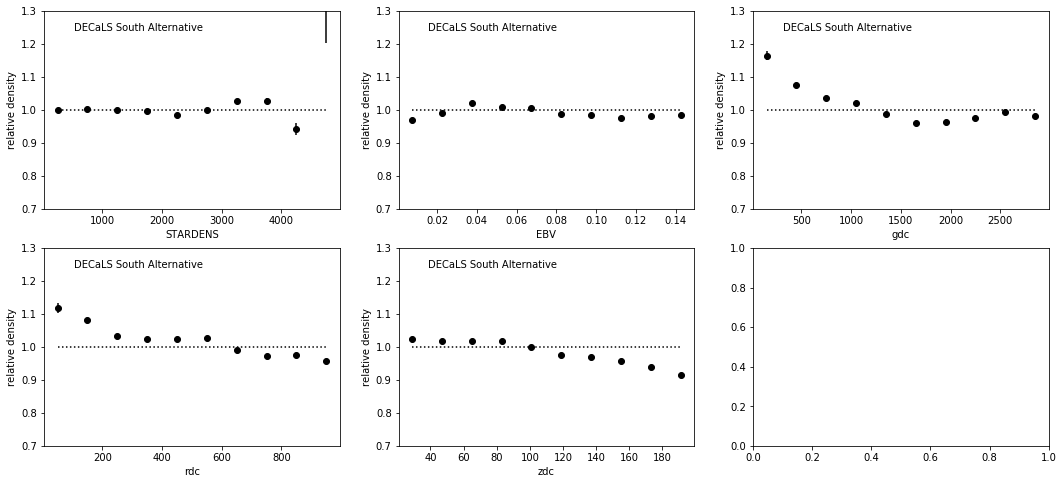

In [10]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

kw   = dict(title='DECaLS South Alternative', effac=2., useMCeff=MCeff) 
    
plotvshp(pixlrds, pixlgds,'STARDENS',(0,0.5e4), **kw, hold=True,  ax=ax[0])
plotvshp(pixlrds, pixlgds,'EBV',     (0,0.15),  **kw, hold=True,  ax=ax[1])
plotvshp(pixlrds, pixlgds,'gdc',     (0,3000),  **kw, hold=True,  ax=ax[2])
plotvshp(pixlrds, pixlgds,'rdc',     (0,1000),  **kw, hold=True,  ax=ax[3])
plotvshp(pixlrds, pixlgds,'zdc',     (20,200),  **kw, hold=False, ax=ax[4])

14577472.0 25508429.0
[0.99738333 1.00676116 0.99210458 0.99859805 0.98200708 0.97654315
 0.98362367 0.98706048 1.03107824        nan]
14577472.0 25508429.0
[0.9572661  1.00287228 1.01800707 0.99965179 0.96732061 0.96014041
 0.94291914 0.9324107  0.92514407 0.90769179]
g depth, extinction corrected


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


14577472.0 25508429.0
[1.18292263 1.04307587 1.00972509 0.98997599 0.97071939 0.96303059
 0.94067648 1.0017191         nan        nan]
14577472.0 25508429.0
[1.00883396 1.05149776 1.0137232  0.99604704 0.97324552 0.94990292
 0.94431517 0.95006674 0.94186503 0.816443  ]
14577472.0 25508429.0
[0.9978642  1.00590858 0.99366147 0.99668223 1.00182126 0.99385595
 0.97895963 1.11185244 1.10721012 1.00143609]


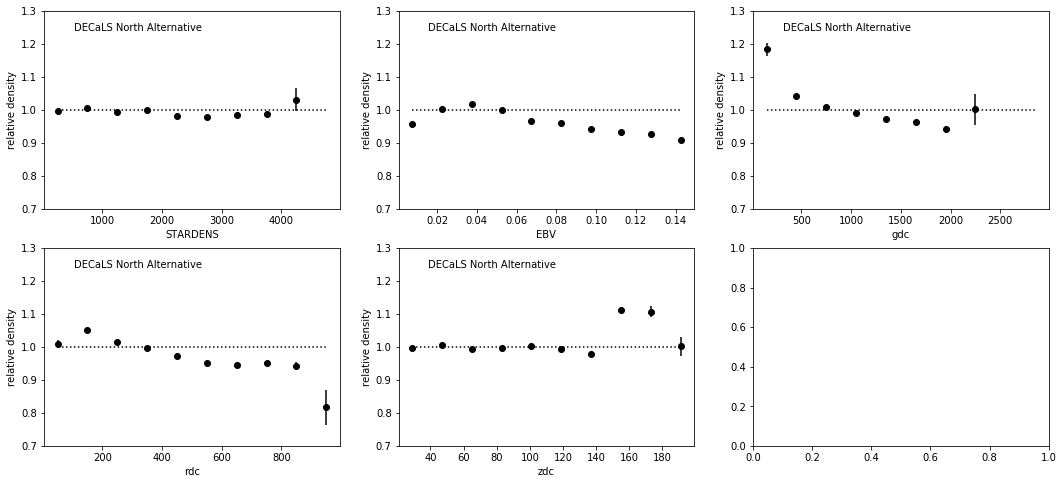

In [11]:
title = 'DECaLS North Alternative'
effac =  2.
slp   = -0.35/4000.
b     =  1.1
ws    =  1./(slp*hpq['STARDENS']+b)
cs    =  True

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()
kw = dict( title=title,effac=effac,correctstar=cs, useMCeff=MCeff)
plotvshp(pixlrdn,pixlgdn,'STARDENS', (0,0.5e4), hold=True,  ax=ax[0], **kw)
plotvshp(pixlrdn,pixlgdn,'EBV',      (0,0.15),  hold=True,  ax=ax[1], **kw)
plotvshp(pixlrdn,pixlgdn,'gdc',      (0,3000),  hold=True,  ax=ax[2], **kw)
plotvshp(pixlrdn,pixlgdn,'rdc',      (0,1000),  hold=True,  ax=ax[3], **kw)
plotvshp(pixlrdn,pixlgdn,'zdc',      (20,200),  hold=False, ax=ax[4], **kw)

12943642.0 22530596.0
[1.02191728 0.98668801 0.97111799 0.99940456 1.03376962 1.08258602
 1.10030668 1.13827846 1.03191139        nan]
12943642.0 22530596.0
[1.01706478 1.02002671 0.9982238  0.98222033 0.92215977 0.88887532
 0.86887055 0.84080001 0.83634629 0.81117002]
g depth, extinction corrected
12943642.0 22530596.0


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


[1.07815552 1.0019253  0.95321954 0.93911139 0.96009392 0.82973392
        nan        nan        nan        nan]
12943642.0 22530596.0
[1.00715564 1.00167388 0.97995849 0.94787847 0.94496402 0.95833279
 0.88543847        nan        nan        nan]
12943642.0 22530596.0
[0.97401968 0.98869426 1.00812525 1.01473356 1.01395972 1.01796339
 1.02507801 1.13748074 1.04223632        nan]


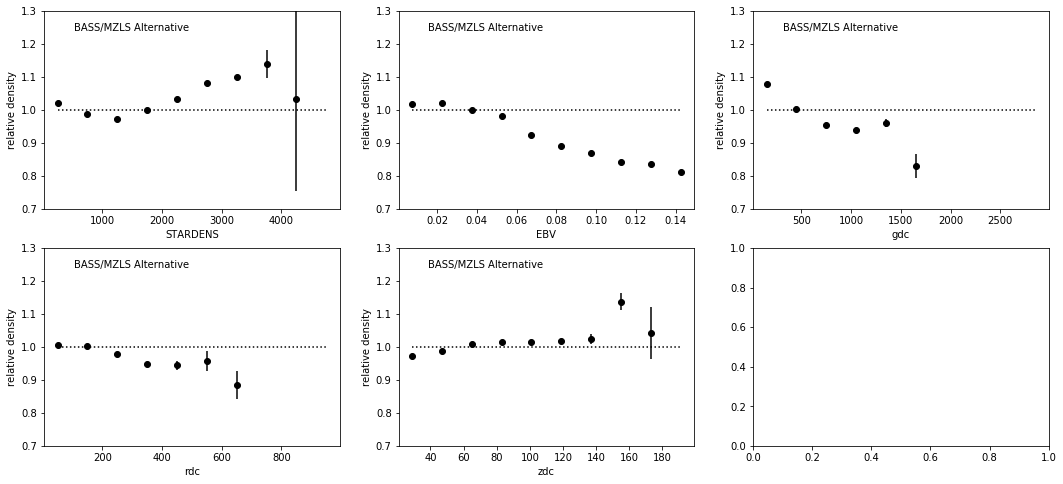

In [12]:

title = 'BASS/MZLS Alternative'
effac=1.
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*hpq['STARDENS']+b)
cs = True



fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()
kw = dict( title=title,effac=effac,correctstar=cs, useMCeff=MCeff)
plotvshp(pixlrbm,pixlgbm,'STARDENS', (0,0.5e4), hold=True,  ax=ax[0], **kw)
plotvshp(pixlrbm,pixlgbm,'EBV',      (0,0.15),  hold=True,  ax=ax[1], **kw)
plotvshp(pixlrbm,pixlgbm,'gdc',      (0,3000),  hold=True,  ax=ax[2], **kw)
plotvshp(pixlrbm,pixlgbm,'rdc',      (0,1000),  hold=True,  ax=ax[3], **kw)
plotvshp(pixlrbm,pixlgbm,'zdc',      (20,200),  hold=False, ax=ax[4], **kw)

In [28]:
'''
Below here, directly use data/randoms
'''

'\nBelow here, directly use data/randoms\n'

In [27]:
#Open files with grids for efficiency and define function to interpolate them (to be improved)
grids = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffgridsouth.dat').transpose()
#grids[3] = grids[3]
gridn = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffgridnorth.dat').transpose()
#print(np.mean(gridn[3]))
#gridn[3] = gridn[3]/np.mean(gridn[3])
def interpeff(gsig,rsig,zsig,south=True):
    md = 0
    xg = 0.15
    #if gsig > xg:
    #    gsig = .99*xg
    xr = 0.15
    #if rsig > xr:
    #    rsig = 0.99*xr
    xz = 0.4
    #if zsig > xz:
    #    zsig = 0.99*xz
    ngp = 30
    if south:
        grid = grids
    else:
        grid = gridn
    i = (ngp*gsig/(xg-md)).astype(int)
    j = (ngp*rsig/(xr-md)).astype(int)
    k = (ngp*zsig/(xz-md)).astype(int)
    ind = (i*ngp**2.+j*ngp+k).astype(int)
    #print(i,j,k,ind)
    #print(grid[0][ind],grid[1][ind],grid[2][ind])
    #print(grid[0][ind-1],grid[1][ind-1],grid[2][ind-1])
    #print(grid[0][ind+1],grid[1][ind+1],grid[2][ind+1])
    return grid[3][ind]
#print(interpeff([0.0],[0.0],[0.0],south=False))   
#print(interpeff(0.0,0.0,0.0,south=True))
#print(0.1/.4)
#print(0.4/30.)
#grid[2][0]

In [29]:
#Get depth values that match those used for efficiency grids
depth_keyword="PSFDEPTH"
R_G=3.214 # http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
R_R=2.165
R_Z=1.211

gsigmad=1./np.sqrt(felg[depth_keyword+"_G"])
rsigmad=1./np.sqrt(felg[depth_keyword+"_R"])
zsigmad=1./np.sqrt(felg[depth_keyword+"_Z"])
gsig = gsigmad*10**(0.4*R_G*felg["EBV"])
w = gsig >= 0.15
gsig[w] = 0.99*0.15
rsig = rsigmad*10**(0.4*R_R*felg["EBV"])
w = rsig >= 0.15
rsig[w] = 0.99*0.15
zsig = zsigmad*10**(0.4*R_Z*felg["EBV"])
w = zsig >= 0.4
zsig[w] = 0.99*0.4


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [30]:
print(min(gsig),max(gsig))
effsouthl = interpeff(gsig,rsig,zsig,south=True)

0.011088011 0.14999883


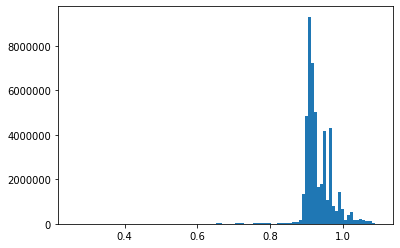

In [31]:
effnorthl = interpeff(gsig,rsig,zsig,south=False)
plt.hist(effnorthl,bins=100)
plt.show()

0.9651708193053623


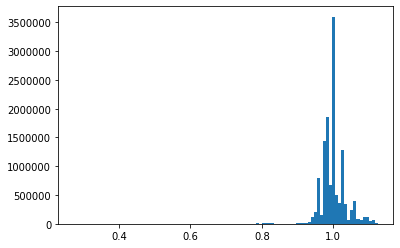

In [32]:
effbm = effnorthl[dbml]
print(np.mean(effbm))
effbm = effbm/np.mean(effbm)
plt.hist(effbm,bins=100)
plt.show()

1.0254885421358475


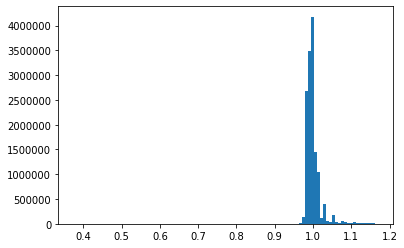

1.0199224461437835


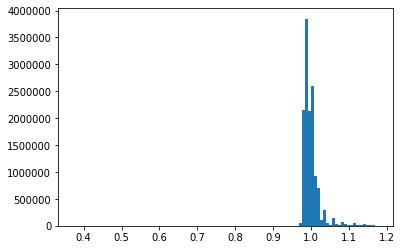

In [33]:
effdn = effsouthl[ddnl]
print(np.mean(effdn))
effdn = effdn/np.mean(effdn)
plt.hist(effdn,bins=100)
plt.show()
#plt.scatter(felg[dbml]['RA'],felg[dbml]['DEC'],c=effbm)
#plt.colorbar()
#plt.show()
effds = effsouthl[ddsl]
print(np.mean(effds))
effds = effds/np.mean(effds)
plt.hist(effds,bins=100)
plt.show()


In [34]:
stardensg = np.zeros(len(felg))
print(len(felg),len(dpix))
for i in range(0,len(dpix)):
    if i%1000000==0 : print(i)
    pix = dpix[i]
    stardensg[i] = hpq['STARDENS'][pix]

47256516 47256516
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000


In [35]:
stardensr = np.zeros(len(relg))
print(len(relg),len(rpix))
for i in range(0,len(rpix)):
    if i%1000000==0 : print(i)
    pix = rpix[i]
    stardensr[i] = hpq['STARDENS'][pix]    

64567641 64567641
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000


In [36]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),weights=1./effbm*ws,range=(0,2000))
hr1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])
#no correction
hgn1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),bins=hg1[1])
hrn1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])

In [37]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),weights=1./effdn**2.*ws,range=(0,3000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])

hgn2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),bins=hg2[1])
hrn2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])

In [38]:
#DECaLS S
#no strong relation with stellar density
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),weights=1./effds**2.,range=(0,2000))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

hgn3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),bins=hg3[1])
hrn3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

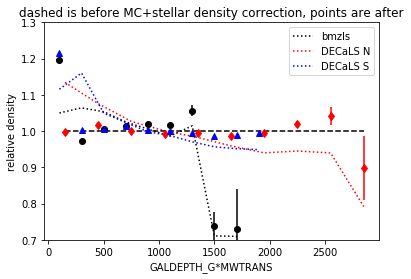

In [41]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [42]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_R']*np.exp(-1.*R_R*felg[dbml]['EBV']),weights=1./effbm*ws,range=(0,500))
hr1 = np.histogram(relg[rbml]['GALDEPTH_R']*np.exp(-1.*R_R*relg[rbml]['EBV']),bins=hg1[1])
hgn1 = np.histogram(felg[dbml]['GALDEPTH_R']*np.exp(-1.*R_R*felg[dbml]['EBV']),bins=hg1[1])


In [43]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(felg[ddnl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddnl]['EBV']),weights=1./effdn**2.*ws,range=(0,1000))
hgn2 = np.histogram(felg[ddnl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddnl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_R']*np.exp(-1.*R_R*relg[rdnl]['EBV']),bins=hg2[1])

In [44]:
#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddsl]['EBV']),weights=1./effds**2.,range=(0,1000))
hgn3 = np.histogram(felg[ddsl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddsl]['EBV']),bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_R']*np.exp(-1.*R_R*relg[rdsl]['EBV']),bins=hg3[1])

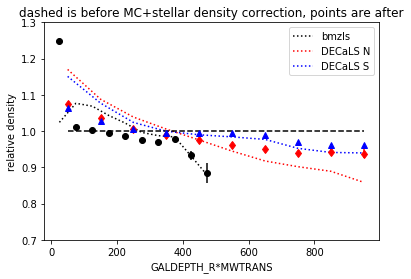

In [46]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_R*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [90]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[dbml]['EBV']),weights=1./effbm*ws,range=(0,200))
hgn1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[dbml]['EBV']),bins=hg1[1])
hr1 = np.histogram(relg[rbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rbml]['EBV']),bins=hg1[1])

In [91]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddnl]['EBV']),weights=1./effdn**2.*ws,range=(0,200))
hgn2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddnl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rdnl]['EBV']),bins=hg2[1])

In [92]:
#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddsl]['EBV']),weights=1./effds**2.,range=(0,200))
hgn3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddsl]['EBV']),bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rdsl]['EBV']),bins=hg3[1])

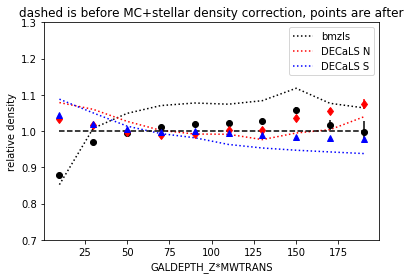

In [93]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_Z*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [100]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(stardensg[dbml],weights=1./effbm,range=(0,5000))
hgn1 = np.histogram(stardensg[dbml],bins=hg1[1])
hr1 = np.histogram(stardensr[rbml],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(stardensg[ddnl],weights=1./effdn**2.,range=(0,5000))
hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(stardensr[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(stardensg[ddsl],weights=1./effds**2.,range=(0,5000))
hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(stardensr[rdsl],bins=hg3[1])

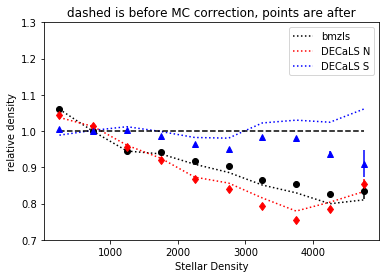

In [102]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm3,'b:')
plt.ylim(.7,1.3)
plt.xlabel('Stellar Density')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC correction, points are after')
plt.show()

In [54]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['EBV'],weights=1./effbm*ws,range=(0,0.15))
hgn1 = np.histogram(felg[dbml]['EBV'],bins=hg1[1])
hr1 = np.histogram(relg[rbml]['EBV'],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(felg[ddnl]['EBV'],weights=1./effdn**2.*ws,range=(0,0.15))
hgn2 = np.histogram(felg[ddnl]['EBV'],bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['EBV'],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(felg[ddsl]['EBV'],weights=1./effds**2.,range=(0,0.15))
hgn3 = np.histogram(felg[ddsl]['EBV'],bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['EBV'],bins=hg3[1])

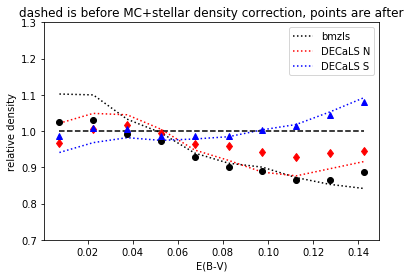

In [56]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('E(B-V)')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [57]:
nh1 = fits.open('NHI_HPX.fits.gz')[1].data['NHI']

In [58]:
#make data column
thphi = radec2thphi(felg['RA'],felg['DEC'])
r = hp.Rotator(coord=['C','G'],deg=False)
thphiG = r(thphi[0],thphi[1])
pixhg = hp.ang2pix(1024,thphiG[0],thphiG[1])
h1g = np.zeros(len(felg))
for i in range(0,len(pixhg)):
    h1g[i] = np.log(nh1[pixhg[i]])
    if i%1000000==0 : print(i)

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000


In [59]:
#make random column
thphi = radec2thphi(relg['RA'],relg['DEC'])
r = hp.Rotator(coord=['C','G'],deg=False)
thphiG = r(thphi[0],thphi[1])
pixhg = hp.ang2pix(1024,thphiG[0],thphiG[1])
h1r = np.zeros(len(relg))
for i in range(0,len(pixhg)):
    h1r[i] = np.log(nh1[pixhg[i]])
    if i%1000000==0 : print(i)

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000


In [60]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(h1g[dbml],weights=1./effbm*ws)
hgn1 = np.histogram(h1g[dbml],bins=hg1[1])
hr1 = np.histogram(h1r[rbml],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(h1g[ddnl],weights=1./effdn**2.*ws)
hgn2 = np.histogram(h1g[ddnl],bins=hg2[1])
hr2 = np.histogram(h1r[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(h1g[ddsl],weights=1./effds**2.)
hgn3 = np.histogram(h1g[ddsl],bins=hg3[1])
hr3 = np.histogram(h1r[rdsl],bins=hg3[1])

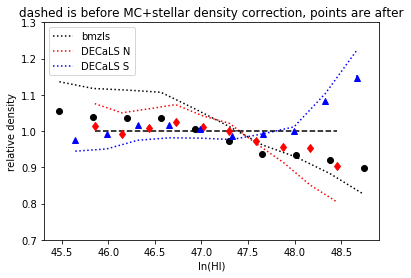

In [61]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('ln(HI)')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

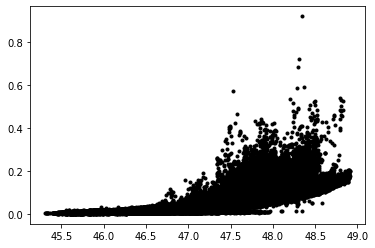

In [62]:
a = np.random.rand(len(relg))
w = a < 0.01
plt.plot(h1r[w],relg[w]['EBV'],'.k')
plt.show()

In [63]:
a,b = np.histogram(h1r,weights=relg['EBV'])
c,d = np.histogram(h1r,bins=b)
print(a)
print(c)


[6.70024597e+02 2.02695586e+04 1.11988445e+05 2.41894156e+05
 3.42473594e+05 5.88525938e+05 7.55287500e+05 4.73316500e+05
 1.13679469e+05 3.10282480e+04]
[   91427  2069447  8104081 11966951 11801914 13830959 11109112  4599702
   789186   204862]


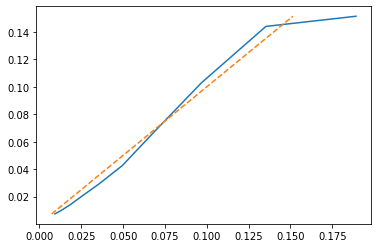

In [64]:
plt.plot(0.008*np.exp(np.array(xl3)-45.5),(a/c))
plt.plot(a/c,a/c,'--')
plt.show()

In [65]:
dhg = felg['EBV']-0.008*np.exp(h1g-45.5)

In [66]:
dhr = relg['EBV']-0.008*np.exp(h1r-45.5)

In [67]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(dhg[dbml],weights=1./effbm*ws,range=(-0.1,.15))
hgn1 = np.histogram(dhg[dbml],bins=hg1[1])
hr1 = np.histogram(dhr[rbml],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(dhg[ddnl],weights=1./effdn**2.*ws,range=(-0.1,.15))
hgn2 = np.histogram(dhg[ddnl],bins=hg2[1])
hr2 = np.histogram(dhr[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(dhg[ddsl],weights=1./effds**2.,range=(-0.1,.15))
hgn3 = np.histogram(dhg[ddsl],bins=hg3[1])
hr3 = np.histogram(dhr[rdsl],bins=hg3[1])

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


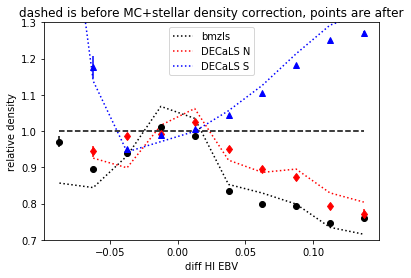

In [68]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('diff HI EBV')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

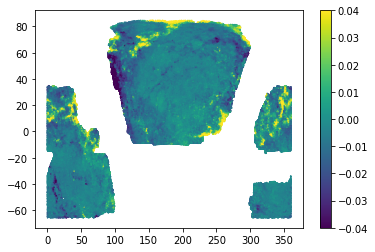

In [69]:
plt.scatter(relg[w]['RA'],relg[w]['DEC'],c=dhr[w],s=.1,vmax=0.04,vmin=-0.04)
plt.colorbar()
plt.show()

In [70]:
wr = abs(dhr) > 0.02
wg = abs(dhg) > 0.02
print(len(relg[wr])/len(relg))
print(len(felg[wg])/len(felg))

0.08020728215856608
0.07749707997940432


In [71]:
#bmzls
w1g = ~wg & dbml
w1r = ~wr & rbml
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[w1g]+b)
wsn = 1./(slp*stardensg[dbml]+b)
effbmw = effnorthl[w1g]
hg1 = np.histogram(felg[w1g]['EBV'],weights=1./effbmw*ws,range=(0,0.15))
hgn1 = np.histogram(felg[dbml]['EBV'],bins=hg1[1],weights=1./effbm*wsn)
hrn1 = np.histogram(relg[rbml]['EBV'],bins=hg1[1])
hr1 = np.histogram(relg[w1r]['EBV'],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
w1g = ~wg & ddnl
w1r = ~wr & rdnl
ws = 1./(slp*stardensg[w1g]+b)
wsn = 1./(slp*stardensg[ddnl]+b)
effdnw = effsouthl[w1g]
hg2 = np.histogram(felg[w1g]['EBV'],weights=1./effdnw**2.*ws,range=(0,0.15))
hgn2 = np.histogram(felg[ddnl]['EBV'],bins=hg2[1],weights=1./effdn**2.*wsn)
hrn2 = np.histogram(relg[rdnl]['EBV'],bins=hg2[1])
hr2 = np.histogram(relg[w1r]['EBV'],bins=hg2[1])

#DECaLS S
w1g = ~wg & ddsl
w1r = ~wr & rdsl
effdsw = effsouthl[w1g]
hg3 = np.histogram(felg[w1g]['EBV'],weights=1./effdsw**2.,range=(0,0.15))
hgn3 = np.histogram(felg[ddsl]['EBV'],bins=hg3[1],weights=1./effds**2.)
hrn3 = np.histogram(relg[rdsl]['EBV'],bins=hg3[1])
hr3 = np.histogram(relg[w1r]['EBV'],bins=hg3[1])

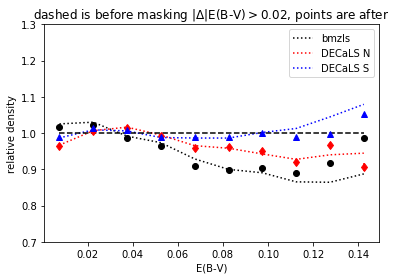

In [74]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0]) 
norm1n = sum(hgn1[0])/sum(hrn1[0]) 
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hrn1[0]/norm1n,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
norm2n = sum(hgn2[0])/sum(hrn2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hrn2[0]/norm2n,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
norm3n = sum(hgn3[0])/sum(hrn3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hrn3[0]/norm3n,'b:')
plt.ylim(.7,1.3)
plt.xlabel('E(B-V)')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title(r'dashed is before masking |$\Delta$|E(B-V)$>0.02$, points are after')
plt.show()

In [ ]:
'''
Divide DECaLS S into DES and non-DES
'''

In [75]:
import pymangle
desply ='/global/cscratch1/sd/raichoor/desits/des.ply'
mng       = pymangle.mangle.Mangle(desply)

In [76]:
polyidd = mng.polyid(felg['RA'],felg['DEC'])
isdesd = polyidd != -1

In [77]:
polyidr = mng.polyid(relg['RA'],relg['DEC'])
isdesr = polyidr != -1

In [79]:
ddsdl = ddsl & isdesd

In [80]:
ddsndl = ddsl & ~isdesd

In [81]:
rdsdl = rdsl & isdesr
rdsndl = rdsl & ~isdesr

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


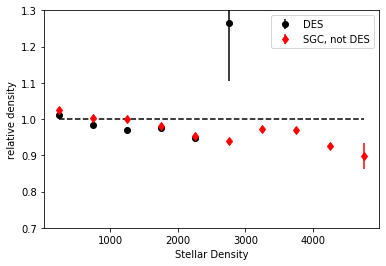

In [85]:
#DECaLS SGC DES
hg1 = np.histogram(stardensg[ddsdl],weights=1./effsouthl[ddsdl]**2.,range=(0,5000))
#hg1 = np.histogram(stardensg[ddsdl],range=(0,5000))
hgn1 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr1 = np.histogram(stardensr[rdsdl],bins=hg1[1])

#DECaLS SGC not DES
hg2 = np.histogram(stardensg[ddsndl],weights=1./effsouthl[ddsndl]**2.,range=(0,5000))
#hg2 = np.histogram(stardensg[ddsndl],range=(0,5000))
hgn2 = np.histogram(stardensg[ddsndl],bins=hg3[1])
hr2 = np.histogram(stardensr[rdsndl],bins=hg2[1])

xl1 = []
xl2 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
plt.ylim(.7,1.3)
plt.xlabel('Stellar Density')
plt.ylabel('relative density')
plt.legend((['DES','SGC, not DES']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

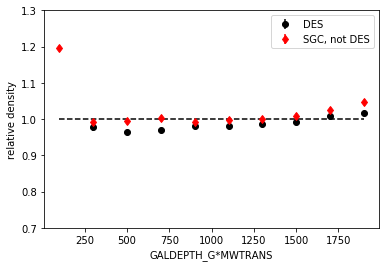

In [96]:
'''
g-band depth
'''
#DECaLS SGC DES


hg1 = np.histogram(felg[ddsdl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsdl]['EBV']),weights=1./effsouthl[ddsdl]**2.,range=(0,2000))
#hg1 = np.histogram(stardensg[ddsdl],range=(0,5000))
hgn1 = np.histogram(felg[ddsdl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsdl]['EBV']),bins=hg1[1])
hr1 = np.histogram(relg[rdsdl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsdl]['EBV']),bins=hg1[1])

#DECaLS SGC not DES
hg2 = np.histogram(felg[ddsndl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsndl]['EBV']),weights=1./effsouthl[ddsndl]**2.,range=(0,2000))
#hg2 = np.histogram(stardensg[ddsndl],range=(0,5000))
hgn2 = np.histogram(felg[ddsndl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsndl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdsndl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsndl]['EBV']),bins=hg2[1])

xl1 = []
xl2 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G*MWTRANS')
plt.ylabel('relative density')
plt.legend((['DES','SGC, not DES']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

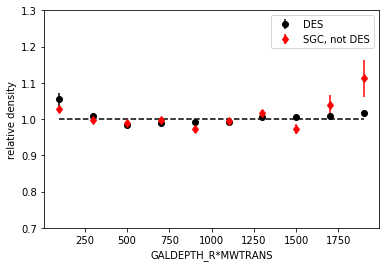

In [97]:
'''
r-band depth
'''
#DECaLS SGC DES


hg1 = np.histogram(felg[ddsdl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddsdl]['EBV']),weights=1./effsouthl[ddsdl]**2.,range=(0,2000))
#hg1 = np.histogram(stardensg[ddsdl],range=(0,5000))
hgn1 = np.histogram(felg[ddsdl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddsdl]['EBV']),bins=hg1[1])
hr1 = np.histogram(relg[rdsdl]['GALDEPTH_R']*np.exp(-1.*R_R*relg[rdsdl]['EBV']),bins=hg1[1])

#DECaLS SGC not DES
hg2 = np.histogram(felg[ddsndl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddsndl]['EBV']),weights=1./effsouthl[ddsndl]**2.,range=(0,2000))
#hg2 = np.histogram(stardensg[ddsndl],range=(0,5000))
hgn2 = np.histogram(felg[ddsndl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddsndl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdsndl]['GALDEPTH_R']*np.exp(-1.*R_R*relg[rdsndl]['EBV']),bins=hg2[1])

xl1 = []
xl2 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_R*MWTRANS')
plt.ylabel('relative density')
plt.legend((['DES','SGC, not DES']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


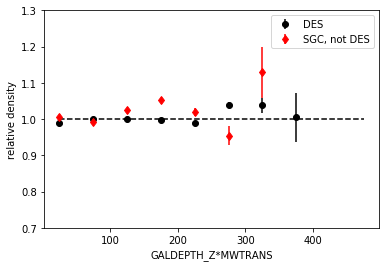

In [99]:
'''
z-band depth
'''
#DECaLS SGC DES


hg1 = np.histogram(felg[ddsdl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddsdl]['EBV']),weights=1./effsouthl[ddsdl]**2.,range=(0,500))
#hg1 = np.histogram(stardensg[ddsdl],range=(0,5000))
hgn1 = np.histogram(felg[ddsdl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddsdl]['EBV']),bins=hg1[1])
hr1 = np.histogram(relg[rdsdl]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rdsdl]['EBV']),bins=hg1[1])

#DECaLS SGC not DES
hg2 = np.histogram(felg[ddsndl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddsndl]['EBV']),weights=1./effsouthl[ddsndl]**2.,range=(0,500))
#hg2 = np.histogram(stardensg[ddsndl],range=(0,5000))
hgn2 = np.histogram(felg[ddsndl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddsndl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdsndl]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rdsndl]['EBV']),bins=hg2[1])

xl1 = []
xl2 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_Z*MWTRANS')
plt.ylabel('relative density')
plt.legend((['DES','SGC, not DES']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [ ]:
'''
Above results didn't quite work at low depth; checking what happens when snr requirements are ignored in the MC
Results are gone, but they basically show that removing the snr requirements makes things worse
'''
grids = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffnosnrgridsouth.dat').transpose()
#grids[3] = grids[3]
gridn = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffnosnrgridnorth.dat').transpose()
effsouthlno = interpeff(gsig,rsig,zsig,south=True)
effnorthlno = interpeff(gsig,rsig,zsig,south=False)

In [ ]:
effbmno = effnorthlno[dbml]
print(np.mean(effbmno))
effbmno = effbmno/np.mean(effbmno)
plt.hist(effbmno,bins=100)
plt.show()

In [ ]:
effdnno = effsouthlno[ddnl]
print(np.mean(effdnno))
effdnno = effdnno/np.mean(effdnno)
plt.hist(effdnno,bins=100)
plt.show()
#plt.scatter(felg[dbml]['RA'],felg[dbml]['DEC'],c=effbm)
#plt.colorbar()
#plt.show()
effdsno = effsouthlno[ddsl]
print(np.mean(effdsno))
effdsno = effdsno/np.mean(effdsno)
plt.hist(effdsno,bins=100)
plt.show()


In [ ]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[dbml]['EBV']),weights=1./effbmno*ws,range=(0,200))
hgn1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[dbml]['EBV']),bins=hg1[1])
hr1 = np.histogram(relg[rbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rbml]['EBV']),bins=hg1[1])

In [ ]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddnl]['EBV']),weights=1./effdnno**2.*ws,range=(0,200))
hgn2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddnl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rdnl]['EBV']),bins=hg2[1])

In [ ]:
#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-1.*R_R*felg[ddsl]['EBV']),weights=1./effdsno**2.,range=(0,200))
hgn3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-1.*R_R*felg[ddsl]['EBV']),bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_Z']*np.exp(-1.*R_R*relg[rdsl]['EBV']),bins=hg3[1])

In [ ]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_Z*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.show()

In [ ]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),weights=1./effbmno*ws,range=(0,2000))
hr1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])
#no correction
hgn1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),bins=hg1[1])
hrn1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])

In [ ]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),weights=1./effdnno**2.*ws,range=(0,3000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])

hgn2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),bins=hg2[1])
hrn2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])

In [ ]:
#DECaLS S
#no strong relation with stellar density
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),weights=1./effdsno**2.,range=(0,2000))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

hgn3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),bins=hg3[1])
hrn3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

In [ ]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.show()